# Класифікація обʼєктів новобудови за текстовим описом за допомогою зворотної нейронної мережі

Рекурсивна нейронна мережа використовується для наборів даних які представляють собою серію послідовних даних. Наприклад, опис обʼєкту нерухомості є текстовою строкою. Кожний символ повʼязаний із попередніми символами та із наступними. Через це використання звичайної нейронної мережі є неможливим при роботі із текстом.

Натомість, для цього використовуються Рекурсивні Нейронні Мережі.

https://www.youtube.com/watch?v=VtRLrQ3Ev-U&ab_channel=freeCodeCamp.org

In [90]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
from keras.models import Sequential
from keras.layers import Dense, Dropout, TextVectorization, Embedding, LSTM
from keras.optimizers import Adam
from keras.utils import to_categorical
# BinaryCrossentropy функція повинна використовуватися для задач бінарної класифікації. Для мультикласової класифікації потрібно використовувати CategoricalCrossentropy
# from keras.losses import BinaryCrossentropy
from keras.losses import CategoricalCrossentropy
from sklearn.model_selection import train_test_split

## Завантаження набору даних

### Ознайомлення з набором даних

In [91]:
df = pd.read_csv('./real-estate-mapped.csv')

### Збереження набору даних для подальшого використання при розробці нового набору даних

In [118]:
df_initial = df.copy();

In [92]:
df.head()

,residence,developer,description,address,district,class,ceilingHeight,numApartmentsTotal,year,pricePerSquareMeter,price,area,rooms,floor,minutesToCityCenter,assess,crimeRateInDistrict
0,А136 Highlight Tower,DIM,Residential complex A136 Highlight Tower is a ...,"вул. Антоновича, 136-138",Голосіївський р-н,бізнес,3,324,2023.0,137800.0,7441200.0,54,1,18.0,48,52536,2317
1,А136 Highlight Tower,DIM,Residential complex A136 Highlight Tower is a ...,"вул. Антоновича, 136-138",Голосіївський р-н,бізнес,3,324,2023.0,137800.0,7992400.0,58,1,NaN,48,52536,2317
2,А136 Highlight Tower,DIM,Residential complex A136 Highlight Tower is a ...,"вул. Антоновича, 136-138",Голосіївський р-н,бізнес,3,324,2023.0,125275.0,10022000.0,80,2,7.0,48,52536,2317
3,А136 Highlight Tower,DIM,Residential complex A136 Highlight Tower is a ...,"вул. Антоновича, 136-138",Голосіївський р-н,бізнес,3,324,2023.0,125275.0,10147275.0,81,2,13.0,48,52536,2317
4,А136 Highlight Tower,DIM,Residential complex A136 Highlight Tower is a ...,"вул. Антоновича, 136-138",Голосіївський р-н,бізнес,3,324,2023.0,125275.0,10648375.0,85,2,17.0,48,52536,2317


In [93]:
df.sample()

,residence,developer,description,address,district,class,ceilingHeight,numApartmentsTotal,year,pricePerSquareMeter,price,area,rooms,floor,minutesToCityCenter,assess,crimeRateInDistrict
62,ЖК LUCKY LAND,DIM,The Lucky Land residential complex is a new re...,"вул. Берковецька, 6",Святошинський р-н,комфорт,2,5183,2023.5,63025.0,1764700.0,28,1,8.5,169,47299,2884


In [94]:
df.shape

(169, 17)

### Фільтрація пустих значень

In [95]:
df = df.dropna()

In [96]:
df.shape

(152, 17)

### Доступні в наборі даних класи нерухомості

In [97]:
df['class'].unique()

array(['бізнес', 'комфорт', 'преміум'], dtype=object)

In [98]:
df.head()

,residence,developer,description,address,district,class,ceilingHeight,numApartmentsTotal,year,pricePerSquareMeter,price,area,rooms,floor,minutesToCityCenter,assess,crimeRateInDistrict
0,А136 Highlight Tower,DIM,Residential complex A136 Highlight Tower is a ...,"вул. Антоновича, 136-138",Голосіївський р-н,бізнес,3,324,2023.0,137800.0,7441200.0,54,1,18.0,48,52536,2317
2,А136 Highlight Tower,DIM,Residential complex A136 Highlight Tower is a ...,"вул. Антоновича, 136-138",Голосіївський р-н,бізнес,3,324,2023.0,125275.0,10022000.0,80,2,7.0,48,52536,2317
3,А136 Highlight Tower,DIM,Residential complex A136 Highlight Tower is a ...,"вул. Антоновича, 136-138",Голосіївський р-н,бізнес,3,324,2023.0,125275.0,10147275.0,81,2,13.0,48,52536,2317
4,А136 Highlight Tower,DIM,Residential complex A136 Highlight Tower is a ...,"вул. Антоновича, 136-138",Голосіївський р-н,бізнес,3,324,2023.0,125275.0,10648375.0,85,2,17.0,48,52536,2317
5,А136 Highlight Tower,DIM,Residential complex A136 Highlight Tower is a ...,"вул. Антоновича, 136-138",Голосіївський р-н,бізнес,3,324,2023.0,125275.0,11024200.0,88,2,14.2,48,52536,2317


### Переведення класів нерухомості до числових значень

In [99]:
class_to_num_map = { 'бізнес': 0, 'преміум': 1, 'комфорт': 2, 'економ': 3 }

df['class'] = df['class'].map(class_to_num_map)

In [100]:
df = df[['description', 'class']]

In [101]:
df.head()

,description,class
0,Residential complex A136 Highlight Tower is a ...,0
2,Residential complex A136 Highlight Tower is a ...,0
3,Residential complex A136 Highlight Tower is a ...,0
4,Residential complex A136 Highlight Tower is a ...,0
5,Residential complex A136 Highlight Tower is a ...,0


## Підготовка даних для тренування моделі

### Створення сету характеристик і міток

TODO: використання imblearn.oversampling -> RandomOverSampler для прирівнювання к-сті зразків певного класу

In [102]:
train, val, test = np.split(df.sample(frac=1), [int(0.8 * len(df)), int(0.9 * len(df))])

In [103]:
train.shape, val.shape, test.shape

((121, 2), (15, 2), (16, 2))

In [104]:
df.head()

,description,class
0,Residential complex A136 Highlight Tower is a ...,0
2,Residential complex A136 Highlight Tower is a ...,0
3,Residential complex A136 Highlight Tower is a ...,0
4,Residential complex A136 Highlight Tower is a ...,0
5,Residential complex A136 Highlight Tower is a ...,0


### Переведення міток до категоріальних значень

Так як мітки в даному випадку варіюються від 1 до 4 що вказує на певний клас будівлі, для того щоб повʼязати ці числа із виходом із softmax вихідного шару нейронної мережі, потрібно перевести числа до категоріального виду використовуюючи допоміжні функції keras.

In [105]:
x_train = train['description'].values
y_train = to_categorical(train['class'], 4)

x_valid = val['description'].values
y_valid = to_categorical(val['class'], 4)

x_test = test['description'].values
y_test = to_categorical(test['class'], 4)

x_pred = ['There is nothing good in this residential complex, please omit it']
y_pred = to_categorical([0], 4)

### Композиція моделі

In [106]:
embedding = 'https://tfhub.dev/google/nnlm-en-dim50/2'
hub_layer = hub.KerasLayer(embedding, dtype=tf.string, trainable=True)

In [107]:
model = Sequential()

model.add(hub_layer)
model.add(Dense(16, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(4, activation='softmax'))

In [108]:
model.compile(optimizer=Adam(learning_rate=0.001), loss=CategoricalCrossentropy(), metrics=['accuracy'])

In [109]:
model.evaluate(x_train, y_train)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


4/4 [==============================] - 1s 5ms/step - loss: 1.9961 - accuracy: 0.1488


[1.996099829673767, 0.1487603336572647]

### Тренування моделі

Попередньо модель була натренована на 10-20 епохах, але цього було недостатньо. Після 10-20 епох точність моделі все ще зростає і модель не переходить в режим Overfitting

In [110]:
history = model.fit(x=x_train, y=y_train, epochs=30, validation_data=(x_valid, y_valid))

Epoch 1/30
4/4 [==============================] - 4s 793ms/step - loss: 1.7905 - accuracy: 0.1488 - val_loss: 1.5584 - val_accuracy: 0.0667
Epoch 2/30
4/4 [==============================] - 3s 828ms/step - loss: 1.3674 - accuracy: 0.2810 - val_loss: 1.2319 - val_accuracy: 0.8000
Epoch 3/30
4/4 [==============================] - 3s 805ms/step - loss: 1.1452 - accuracy: 0.8678 - val_loss: 1.1219 - val_accuracy: 0.8000
Epoch 4/30
4/4 [==============================] - 3s 736ms/step - loss: 1.0459 - accuracy: 0.8430 - val_loss: 1.0571 - val_accuracy: 0.7333
Epoch 5/30
4/4 [==============================] - 3s 731ms/step - loss: 0.9631 - accuracy: 0.8347 - val_loss: 0.9846 - val_accuracy: 0.7333
Epoch 6/30
4/4 [==============================] - 3s 778ms/step - loss: 0.8788 - accuracy: 0.8430 - val_loss: 0.9119 - val_accuracy: 0.8000
Epoch 7/30
4/4 [==============================] - 3s 766ms/step - loss: 0.8035 - accuracy: 0.9421 - val_loss: 0.8488 - val_accuracy: 1.0000
Epoch 8/30
4/4 [====

### Результати тренування моделі

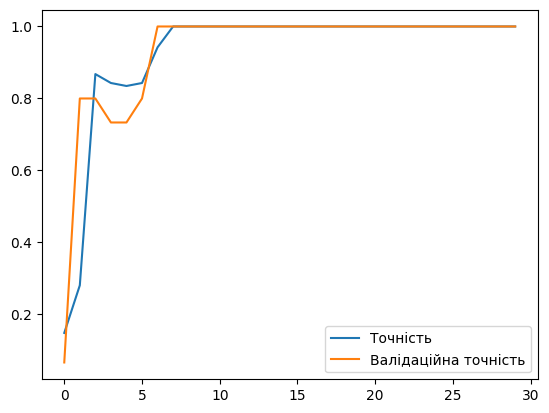

In [111]:
plt.plot(history.history['accuracy'], label="Точність")
plt.plot(history.history['val_accuracy'], label="Валідаційна точність")
plt.legend()

plt.show()

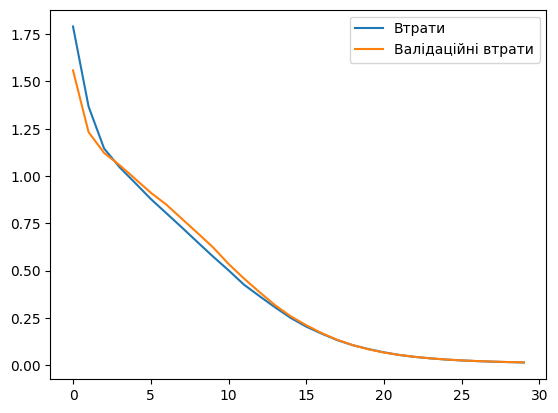

In [112]:
plt.plot(history.history['loss'], label="Втрати")
plt.plot(history.history['val_loss'], label="Валідаційні втрати")
plt.legend()

plt.show()

## Перевірка моделі на тестових даних яких раніше модель не бачила

In [113]:
def pred_to_text(pred):
    return list(class_to_num_map.keys())[list(class_to_num_map.values()).index(pred)]

In [114]:
pred_to_text(0), pred_to_text(1), pred_to_text(2), pred_to_text(3)

('бізнес', 'преміум', 'комфорт', 'економ')

In [115]:
model.evaluate(x_test, y_test)

1/1 [==============================] - 0s 156ms/step - loss: 0.0127 - accuracy: 1.0000


[0.012721220031380653, 1.0]

In [116]:
pred = model.predict(x_pred)
pred_index = np.argmax(pred)

pred_to_text(pred_index)

1/1 [==============================] - 0s 249ms/step


'комфорт'

TODO: створити новий набір даних із результатами роботи нейронної мережі і передати його на вхід до алгоритму лінійної регресії для оцінки вартості нерухомості

## Генерація нового набору даних із результатами роботи нейронної мережі

In [120]:
predicted = model.predict(df_initial['description'].values)
predicted

5/5 [==============================] - 1s 136ms/step


array([[9.77175295e-01, 7.59123173e-03, 1.31663205e-02, 2.06716731e-03],
       [9.77175295e-01, 7.59123173e-03, 1.31663205e-02, 2.06716731e-03],
       [9.77175295e-01, 7.59123173e-03, 1.31663205e-02, 2.06716731e-03],
       [9.77175295e-01, 7.59123173e-03, 1.31663205e-02, 2.06716731e-03],
       [9.77175295e-01, 7.59123173e-03, 1.31663205e-02, 2.06716731e-03],
       [6.37453701e-03, 5.27822762e-04, 9.89589870e-01, 3.50774475e-03],
       [6.37453701e-03, 5.27822762e-04, 9.89589870e-01, 3.50774475e-03],
       [6.37453701e-03, 5.27822762e-04, 9.89589870e-01, 3.50774475e-03],
       [6.37453701e-03, 5.27822762e-04, 9.89589870e-01, 3.50774475e-03],
       [6.37453701e-03, 5.27822762e-04, 9.89589870e-01, 3.50774475e-03],
       [6.37453701e-03, 5.27822762e-04, 9.89589870e-01, 3.50774475e-03],
       [6.37453701e-03, 5.27822762e-04, 9.89589870e-01, 3.50774475e-03],
       [6.37453701e-03, 5.27822762e-04, 9.89589870e-01, 3.50774475e-03],
       [6.37453701e-03, 5.27822762e-04, 9.89589870e

In [122]:
predicted_to_human_readable = list(map(lambda categorical: pred_to_text(np.argmax(categorical)), predicted))
predicted_to_human_readable

['бізнес',
 'бізнес',
 'бізнес',
 'бізнес',
 'бізнес',
 'комфорт',
 'комфорт',
 'комфорт',
 'комфорт',
 'комфорт',
 'комфорт',
 'комфорт',
 'комфорт',
 'комфорт',
 'комфорт',
 'комфорт',
 'комфорт',
 'комфорт',
 'комфорт',
 'комфорт',
 'комфорт',
 'комфорт',
 'комфорт',
 'комфорт',
 'комфорт',
 'комфорт',
 'комфорт',
 'комфорт',
 'комфорт',
 'комфорт',
 'комфорт',
 'комфорт',
 'комфорт',
 'комфорт',
 'комфорт',
 'комфорт',
 'комфорт',
 'комфорт',
 'комфорт',
 'комфорт',
 'комфорт',
 'комфорт',
 'комфорт',
 'комфорт',
 'комфорт',
 'комфорт',
 'комфорт',
 'комфорт',
 'комфорт',
 'комфорт',
 'комфорт',
 'комфорт',
 'комфорт',
 'комфорт',
 'комфорт',
 'комфорт',
 'комфорт',
 'комфорт',
 'комфорт',
 'комфорт',
 'комфорт',
 'комфорт',
 'комфорт',
 'комфорт',
 'комфорт',
 'комфорт',
 'комфорт',
 'комфорт',
 'комфорт',
 'комфорт',
 'комфорт',
 'комфорт',
 'комфорт',
 'комфорт',
 'комфорт',
 'бізнес',
 'бізнес',
 'бізнес',
 'бізнес',
 'бізнес',
 'бізнес',
 'бізнес',
 'бізнес',
 'бізнес',
 'бізн

In [123]:
crafted_dataset = df_initial.copy()

In [144]:
crafted_dataset.shape, len(predicted_to_human_readable)

((152, 3), 152)

In [139]:
crafted_dataset['predictedClass'] = predicted_to_human_readable

In [140]:
crafted_dataset

,description,class,predictedClass
0,Residential complex A136 Highlight Tower is a ...,0,бізнес
2,Residential complex A136 Highlight Tower is a ...,0,бізнес
3,Residential complex A136 Highlight Tower is a ...,0,бізнес
4,Residential complex A136 Highlight Tower is a ...,0,бізнес
5,Residential complex A136 Highlight Tower is a ...,0,бізнес
...,...,...,...
158,The 4 Seasons residential complex in Kyiv is a...,2,комфорт
159,The 4 Seasons residential complex in Kyiv is a...,2,комфорт
160,The 4 Seasons residential complex in Kyiv is a...,2,комфорт
161,The 4 Seasons residential complex in Kyiv is a...,2,комфорт


In [145]:
crafted_dataset.to_csv('real-estate-with-nn-results.csv', encoding='utf-8')